# Inferencia Bayesiana con métodos MonteCarlo: Cadenas de Markov

Probamos el método de Metropolis-Hasting para MCMC y lo comparamos con la función de luminosidad en función de la magnitud absoluta de la banda r del Sloan, medidas en el trabajo de Blanton et al. (2001).

In [1]:
import numpy as np
import pandas as pd 
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
d = pd.read_table('datos.dat',sep='\t', header=None, names=['Magnitud','Fl_inf','Flujo','Fl_sup'])
Fer_i = d['Flujo']-d['Fl_inf']
Fer_s = d['Fl_sup']-d['Flujo']
M = d['Magnitud']
F = d['Flujo']

En el gráfico se ven los puntos junto con sus errores en escala logarítmica

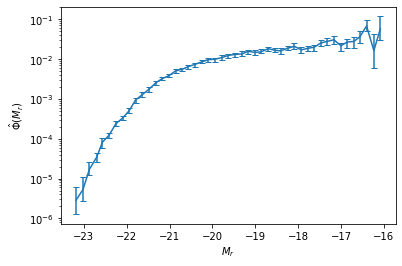

In [3]:
plt.errorbar(d['Magnitud'],d['Flujo'],yerr=[Fer_i,Fer_s], capsize=3)
plt.xlabel('$M_r$')
plt.ylabel('$\hat{\Phi}(M_r)$')
plt.yscale('log')

Escribo la función del modelo, el Likelihood, un prior uniforme y uno normal y la posteriori todos exepto el modelo tomando el logaritmo.
Después escribo la cadena según el algoritmo elegido (MH).

In [4]:
def mod(M,Ms,fs,a):
    """ Modelo de Blanton para los flujos
    M  : Magnitud observada
    Ms : Manitud del modelo
    fs : Flujo del modelo
    a  : alpha del modelo
    """
    import numpy as np
    Fm = np.zeros(len(M))
    Fm = 0.4*np.log(10)*fs*10**(-0.4*(M-Ms)*(a+1))*np.exp(-10**(-0.4*(M-Ms)))
    return Fm

Tomo un Likelihood gaussiano, es decir que la probabilidad de los datos dado el modelo sigue una distribución normal según la hipótesis adoptada. Además, dado que el error de las mediciones es asimétrico considero $\sigma_i = \frac{\epsilon_-+\epsilon_+}{2}$. $$L := p({F_{i} } | \Phi_*, \sigma_i ) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi} \sigma_i} exp(\frac{-(F_{i}-\Phi_*)^2}{2 \sigma_i}),$$ al cual le tomo el logaritmo, si $\sigma_i= \sigma$ constante entonces:
$$ln[L(\mu)] = constant -
\sum_{i=1}^{N} \frac{(F_{i} - \Phi_*)^2}{2 \sigma^2}$$

In [5]:
def lkl(M,F,Fer_i,Fer_s,Ms,fs,a):
    """ Logaritmo del likelihood 
    para distribución normal alrededor de cada punto
    M     : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms    : Magnitud del modelo
    fs    : Flujo del modelo
    a     : alpha del modelo
    """
    import scipy.stats as st
    import numpy as np
    
    Fm = mod(M,Ms,fs,a)
    sigma = (Fer_i[:]+Fer_s[:])*0.5
    lk = st.norm(Fm, sigma).pdf(F)
    lk = np.log(lk)
    return np.sum(lk)

El prior uniforme vale 1 si me encuentro dentro del rango de parámetros elegido y 0 si salgo del intervalo. En escala logaritmica esto equivale a 0 y $-\infty$ respectivamente.

In [6]:
def priorU(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Prior Uniforme
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud mínima del modelo
    Ms_s : Magnitud máxima del modelo
    fs_i : Flujo mínima del modelo
    fs_s : Flujo máxima del modelo
    a_i  : alpha mínima del modelo
    a_s  : alpha máxima del modelo
    """
    import scipy.stats as st
    import numpy as np
    
    Mpr = st.uniform.pdf(Ms,loc=Ms_i,scale=(Ms_s-Ms_i))
    Fpr = st.uniform.pdf(fs,loc=fs_i,scale=(fs_s-fs_i))
    apr = st.uniform.pdf(a,loc=a_i,scale=(a_s-a_i))
    if (Mpr*Fpr*apr)==0:
        return -np.inf
    else:
        return np.log(Mpr*Fpr*apr)

Para el prior normal elijo $\sigma$ con ancho de medio intervalo.

In [7]:
def priorN(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Prior Normal
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud menor del modelo a un sigma del valor central
    Ms_s : Magnitud mayor del modelo a un sigma del valor central
    fs_i : Flujo menor del modelo a un sigma del valor central 
    fs_s : Flujo mayor del modelo a un sigma del valor central
    a_i  : alpha menor del modelo a un sigma del valor central
    a_s  : alpha mayor del modelo a un sigma del valor central
    """
    import scipy.stats as st
    import numpy as np
    
    Mpr = st.norm.pdf(Ms,loc=(Ms_i+Ms_s)*0.5,scale=0.5*(Ms_s-Ms_i))
    Fpr = st.norm.pdf(fs,loc=(fs_i+fs_s)*0.5,scale=0.5*(fs_s-fs_i))
    apr = st.norm.pdf(a,loc=(a_i+a_s)*0.5,scale=0.5*(a_s-a_i))
    if (Mpr*Fpr*apr)==0:
        return -np.inf
    else:
        return np.log(Mpr*Fpr*apr)

La posteriori logaritmica correspondiente al Prior uniforme.

In [8]:
def postU(M,F,Fer_i,Fer_s,Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Posterior de un prior Uniforme
    M     : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud mínima del modelo
    Ms_s : Magnitud máxima del modelo
    fs_i : Flujo mínima del modelo
    fs_s : Flujo máxima del modelo
    a_i  : alpha mínima del modelo
    a_s  : alpha máxima del modelo
    """
    pos = lkl(M,F,Fer_i,Fer_s,Ms,fs,a) + priorU(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    return pos

La posteriori logaritmica correspondiente al Prior normal.

In [9]:
def postN(M,F,Fer_i,Fer_s,Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Posterior de un prior Normal
    M     : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud menor del modelo a un sigma del valor central
    Ms_s : Magnitud mayor del modelo a un sigma del valor central
    fs_i : Flujo menor del modelo a un sigma del valor central 
    fs_s : Flujo mayor del modelo a un sigma del valor central
    a_i  : alpha menor del modelo a un sigma del valor central
    a_s  : alpha mayor del modelo a un sigma del valor central
    """
    pos = lkl(M,F,Fer_i,Fer_s,Ms,fs,a) + priorN(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    return pos

Cadena con posteriori inicial distinta de 0 y saltos con $\sigma = 0.1 \Delta P$, donde $P$ son los parámetros {$M_*, \Phi_*, a$}.

In [10]:
def MCMC(n,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    import numpy as np
    
    step    = []
    post    = []
    M_chain = []
    F_chain = []
    a_chain = []
    Mc = 0.5*(Ms_i+Ms_s)
    Fc = 0.5*(fs_i+fs_s)
    ac = 0.5*(a_i+a_s)
    delM = Ms_s-Ms_i
    delF = fs_s-fs_i
    dela = fs_s-fs_i
    
    post_0 = -101 # Mi posterior esta en logaritmo
    while post_0 < -100:
        Ms_0 = np.random.uniform(Ms_i, Ms_s)
        fs_0 = np.random.uniform(fs_i, fs_s)
        a_0  = np.random.uniform(a_i, a_s)
    
        post_0 = postU(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    
    i = 0
    step.append(i)
    post.append(post_0)
    M_chain.append(Ms_0)
    F_chain.append(fs_0)
    a_chain.append(a_0)
    
    for i in range(1,n):
        Ms_n = np.random.normal(loc= Ms_0, scale= 0.1*delM)
        fs_n = np.random.normal(loc= fs_0, scale= 0.1*delF)
        a_n  = np.random.normal(loc=  a_0, scale= 0.1*dela)
        
        post_n = postU(M,F,Fer_i,Fer_s,Ms_n,fs_n,a_n,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
        
        # Probabilidad de aceptación (las posteriores estaban en logaritmo):
        p_ac = min(1., np.exp(post_n - post_0))
    
        if (np.random.rand() < p_ac):
            Ms_0   = Ms_n
            fs_0   = fs_n
            a_0    = a_n
            post_0 = post_n
            
        step.append(i)
        M_chain.append(Ms_0)
        F_chain.append(fs_0)
        a_chain.append(a_0)
        post.append(post_0)
    
    return step, M_chain, F_chain, a_chain, post

Elijo valores límite para los parámetros y grafíco los modelos límite resultantes para asegurarme que el rango elegido sea razonable.

In [11]:
Ms_i = -21.2
Ms_s = -20.4
fs_i = 0.011
fs_s = 0.017
a_i = -1.3
a_s = -1.1
Mb = -20.83
Fb = 0.0146
ab = -1.2
mod_lim = np.zeros([len(M),8])
mod_lim[:,0] = mod(M,Ms_i,fs_i,a_i)
mod_lim[:,1] = mod(M,Ms_s,fs_i,a_i)
mod_lim[:,2] = mod(M,Ms_i,fs_s,a_i)
mod_lim[:,3] = mod(M,Ms_s,fs_s,a_i)
mod_lim[:,4] = mod(M,Ms_i,fs_i,a_s)
mod_lim[:,5] = mod(M,Ms_s,fs_s,a_s)
mod_lim[:,6] = mod(M,Ms_i,fs_i,a_s)
mod_lim[:,7] = mod(M,Ms_s,fs_s,a_s)

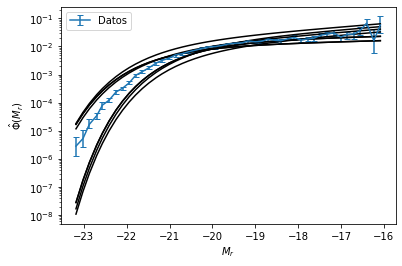

In [12]:
plt.errorbar(d['Magnitud'],d['Flujo'],yerr=[Fer_i,Fer_s], capsize=3, label='Datos')
for i in range(8):
    plt.plot(M,mod_lim[:,i],c='k')
plt.legend()
plt.xlabel('$M_r$')
plt.ylabel('$\hat{\Phi}(M_r)$')
plt.yscale('log')

In [13]:
%%time 
n = 5000
step, M_chain, F_chain, a_chain, post = MCMC(n,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)

CPU times: user 18.6 s, sys: 13.3 ms, total: 18.6 s
Wall time: 18.6 s


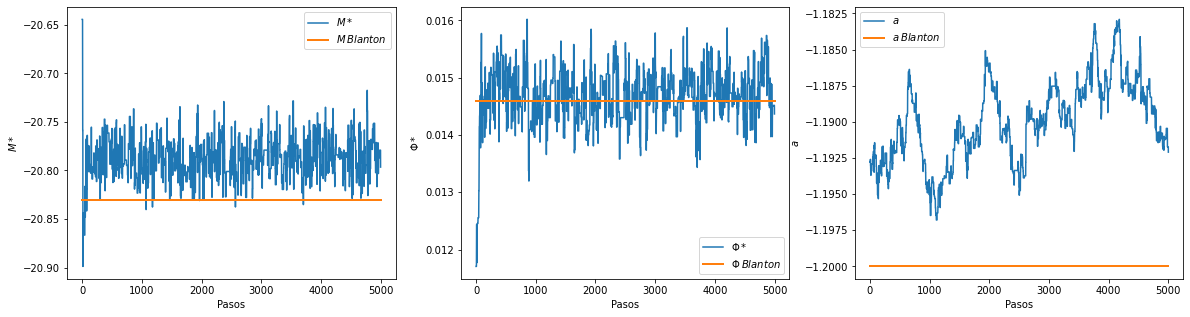

In [14]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

ax1.plot(step,M_chain, label='$M*$')
ax1.plot([0,n],[Mb,Mb], lw=2, label='$M\: Blanton$')
ax2.plot(step,F_chain,label='$\Phi *$')
ax2.plot([0,n],[Fb,Fb], lw=2, label='$\Phi\: Blanton$')
ax3.plot(step,a_chain, label='$a$')
ax3.plot([0,n],[ab,ab], lw=2, label='$a\: Blanton$')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('Pasos')
ax2.set_xlabel('Pasos')
ax3.set_xlabel('Pasos')
ax1.set_ylabel('$M*$')
ax2.set_ylabel('$\Phi *$')
ax3.set_ylabel('$a$')
plt.show()

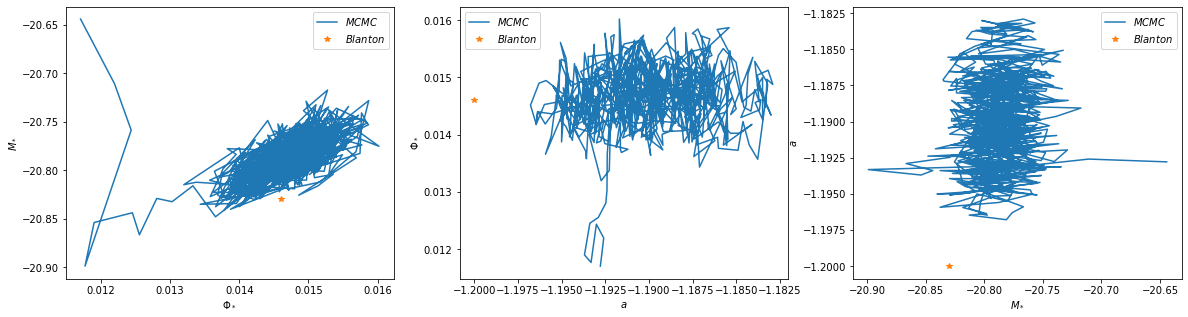

In [15]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

ax1.plot(F_chain,M_chain, label='$MCMC$')
ax1.plot(Fb,Mb, '*', label='$Blanton$')
ax2.plot(a_chain,F_chain,label='$MCMC$')
ax2.plot(ab,Fb, '*', label='$Blanton$')
ax3.plot(M_chain,a_chain, label='$MCMC$')
ax3.plot(Mb,ab, '*', label='$Blanton$')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('$\Phi_*$')
ax2.set_xlabel('$a$')
ax3.set_xlabel('$M_*$')
ax1.set_ylabel('$M_*$')
ax2.set_ylabel('$\Phi_*$')
ax3.set_ylabel('$a$')
plt.show()

-20.786964091312573 0.014695470520230685 -1.1897078224079294


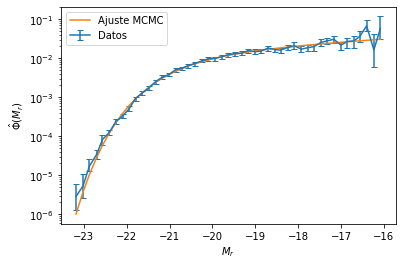

In [16]:
print(np.mean(M_chain[n//10:]),np.mean(F_chain[n//10:]),np.mean(a_chain[n//10:]))
mod_chain = mod(M,np.mean(M_chain[n//10:]),np.mean(F_chain[n//10:]),np.mean(a_chain[n//10:]))
plt.errorbar(d['Magnitud'],d['Flujo'],yerr=[Fer_i,Fer_s], capsize=3, label='Datos')
plt.plot(M, mod_chain, label= 'Ajuste MCMC')
plt.legend()
plt.xlabel('$M_r$')
plt.ylabel('$\hat{\Phi}(M_r)$')
plt.yscale('log')

In [17]:
postU(M,F,Fer_i,Fer_s,Mb,Fb,ab,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s),max(post)

(286.4698510919069, 290.9371598733372)

Veo que la poteriori de los parámetros de Blanton no es la máxima encontrada por la cadena, esto indicaría que hay parámetros mejores.

Ahora corro varias cadenas y guardo sus valores promedio.

In [19]:
nc = 100
Chains = np.zeros([3,nc])
for j in range(nc):
    step, M_chain, F_chain, a_chain, post = MCMC(n,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    Chains[0,j] = np.mean(M_chain[n//10:])
    Chains[1,j] = np.mean(F_chain[n//10:])
    Chains[2,j] = np.mean(a_chain[n//10:])

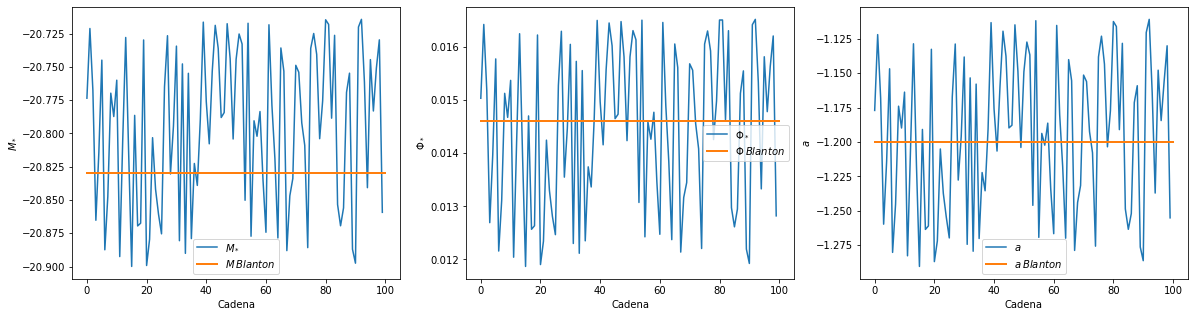

In [20]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))
n_chain = np.arange(0,nc)

ax1.plot(n_chain,Chains[0,:], label='$M_*$')
ax1.plot([0,nc],[Mb,Mb], lw=2, label='$M\: Blanton$')
ax2.plot(n_chain,Chains[1,:],label='$\Phi_*$')
ax2.plot([0,nc],[Fb,Fb], lw=2, label='$\Phi\: Blanton$')
ax3.plot(n_chain,Chains[2,:], label='$a$')
ax3.plot([0,nc],[ab,ab], lw=2, label='$a\: Blanton$')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('Cadena')
ax2.set_xlabel('Cadena')
ax3.set_xlabel('Cadena')
ax1.set_ylabel('$M_*$')
ax2.set_ylabel('$\Phi_*$')
ax3.set_ylabel('$a$')
plt.show()

In [21]:
print(f' El parametro M medio de las cadenas es: {np.mean(Chains[0,:])} +/- {np.std(Chains[0,:])}')
print(f' El parametro F medio de las cadenas es: {np.mean(Chains[1,:])} +/- {np.std(Chains[1,:])}')
print(f' El parametro a medio de las cadenas es: {np.mean(Chains[2,:])} +/- {np.std(Chains[2,:])}')

 El parametro M medio de las cadenas es: -20.795870257981605 +/- 0.05805171192852859
 El parametro F medio de las cadenas es: 0.014477138383168992 +/- 0.0014869810951967746
 El parametro a medio de las cadenas es: -1.1947895367008987 +/- 0.05457317185809036


Los parámetros obtenidos son semejantes a los de Blanton y en el caso de $\Phi *$ es indistinguible.

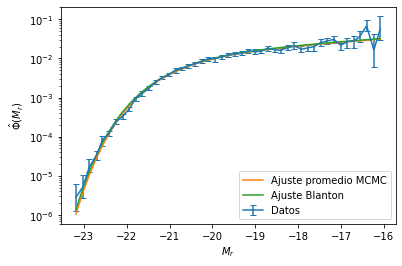

In [22]:
mod_chainR  = mod(M,np.mean(Chains[0,:]),np.mean(Chains[1,:]),np.mean(Chains[2,:]))
mod_Blanton = mod(M, Mb,Fb,ab)
plt.errorbar(d['Magnitud'],d['Flujo'],yerr=[Fer_i,Fer_s], capsize=3, label='Datos')
plt.plot(M, mod_chainR, label='Ajuste promedio MCMC')
plt.plot(M,mod_Blanton, label='Ajuste Blanton')
plt.legend()
plt.xlabel('$M_r$')
plt.ylabel('$\hat{\Phi}(M_r)$')
plt.yscale('log')

Si bien las cadenas individuales obtienen valores distintos al de Blanton, al promediar varias consigo resultados que concuerdan.

## Gradiente Descendiente

El algoritmo de gradiente descendiente se basa en aumentar el estimador (en este caso será el logaritmo de la posteriori, que asumiendo priors uniformes se vuelve el log del Likelihood) haciendo pasos en la dirección del gradiente, la convergencia se alcanza al hacerse nulo el gradiente. Como $\sigma_i$ no depende de los parámetros la tomo como constante.
$$\nabla_P ln[L(\vec{P}_{old})] = \nabla_P(constant -
\sum_{i=1}^{N} \frac{(F_{i} - \Phi_*)^2}{2 \sigma^2})$$
$$= -\sum_{i=1}^{N} \left(\frac{(F_{i} - \Phi_*)}{\sigma^2}\cdot(- \nabla_P \Phi_*) \right)$$

El algorimo es:
$\vec{P}_{new} = \vec{P}_{old}+ \eta \cdot \nabla ln[L(\vec{P}_{old})]$

In [23]:
def G_lkl(M,F,Fer_i,Fer_s,Ms,fs,a):
    """ Gradiente del logaritmo del likelihood
    para el modelo de Blanton 
    M  : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms : Manitud del modelo
    fs : Flujo del modelo
    a  : alpha del modelo
    """
    Fm = mod(M,Ms,fs,a)
    sigma = (Fer_i[:]+Fer_s[:])*0.5
    der1 = (F-Fm)/sigma**2
    der_Ms = 0.4*np.log(10)*((a+1)-10**(-0.4*(M-Ms)))*mod(M,Ms,fs,a)
    der_fs = mod(M,Ms,fs,a)/fs
    der_a = -0.4*np.log(10)*(M-Ms)*mod(M,Ms,fs,a)
    
    Glk_M = np.sum(der1 * der_Ms)
    Glk_F = np.sum(der1 * der_fs)
    Glk_a = np.sum(der1 * der_a)
    Glk = np.array([Glk_M,Glk_F,Glk_a])
    return Glk

In [24]:
def GD(nG,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s,eta):
    import numpy as np
    
    itern  = []
    lkl_GD = []
    M_GD   = []
    F_GD   = []
    a_GD   = []
    
    lkl_0 = -101 # Mi likelihood esta en logaritmo
    while lkl_0 < -100:
        Ms_0 = np.random.uniform(Ms_i, Ms_s)
        fs_0 = np.random.uniform(fs_i, fs_s)
        a_0  = np.random.uniform(a_i, a_s)
    
        lkl_0 = lkl(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0)
    
    # Porque el gradiente puede ser muy grande/chico respecto al valor de la variable
    # elijo eta = n% crecimiento en dir del grad.
    eta = eta / np.linalg.norm(G_lkl(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0))
    i = 0
    itern.append(i)
    lkl_GD.append(lkl_0)
    M_GD.append(Ms_0)
    F_GD.append(fs_0)
    a_GD.append(a_0)
    
    for i in range(1,nG):
        Ms_n = Ms_0 + eta[0]*G_lkl(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0)[0]
        fs_n = fs_0 + eta[1]*G_lkl(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0)[1]
        a_n  = a_0 + eta[2]*G_lkl(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0)[2]
        
        lkl_n =  lkl(M,F,Fer_i,Fer_s,Ms_n,fs_n,a_n)

        Ms_0   = Ms_n
        fs_0   = fs_n
        a_0    = a_n
        lkl_0 = lkl_n
            
        itern.append(i)
        lkl_GD.append(lkl_0)
        M_GD.append(Ms_0)
        F_GD.append(fs_0)
        a_GD.append(a_0)
        
    return itern, M_GD, F_GD, a_GD, lkl_GD

In [25]:
%%time 
nG = 2000
eta = np.array([0.1,0.001,1.])
itern, M_GD, F_GD, a_GD, lkl_GD = GD(nG,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s,eta)

CPU times: user 1min 14s, sys: 7.85 ms, total: 1min 14s
Wall time: 1min 14s


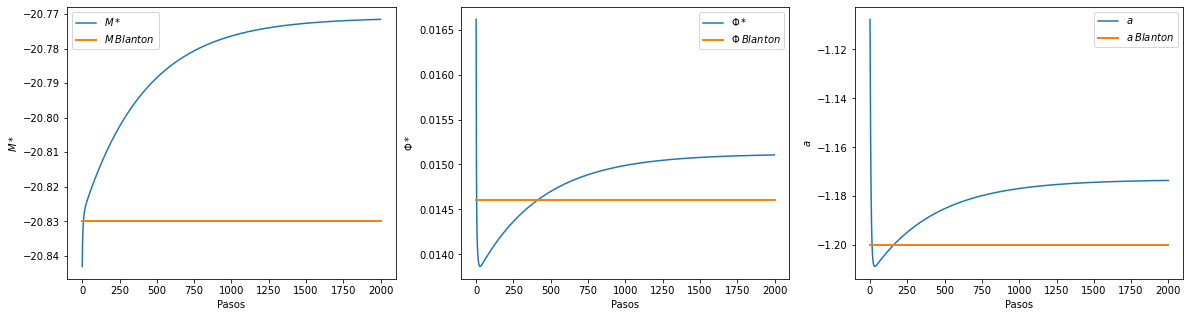

In [26]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

ax1.plot(itern,M_GD, label='$M*$')
ax1.plot([0,nG],[Mb,Mb], lw=2, label='$M\: Blanton$')
ax2.plot(itern,F_GD,label='$\Phi *$')
ax2.plot([0,nG],[Fb,Fb], lw=2, label='$\Phi\: Blanton$')
ax3.plot(itern,a_GD, label='$a$')
ax3.plot([0,nG],[ab,ab], lw=2, label='$a\: Blanton$')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('Pasos')
ax2.set_xlabel('Pasos')
ax3.set_xlabel('Pasos')
ax1.set_ylabel('$M*$')
ax2.set_ylabel('$\Phi *$')
ax3.set_ylabel('$a$')
plt.show()

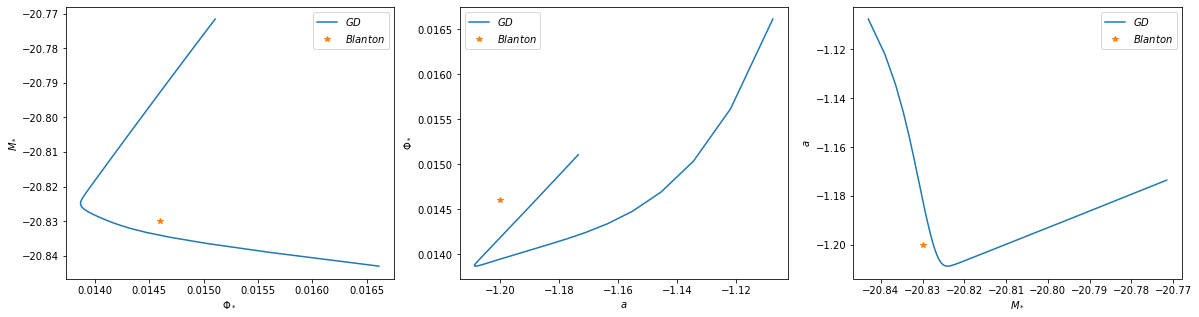

In [27]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

ax1.plot(F_GD,M_GD, label='$GD$')
ax1.plot(Fb,Mb, '*', label='$Blanton$')
ax2.plot(a_GD,F_GD,label='$GD$')
ax2.plot(ab,Fb, '*', label='$Blanton$')
ax3.plot(M_GD,a_GD, label='$GD$')
ax3.plot(Mb,ab, '*', label='$Blanton$')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('$\Phi_*$')
ax2.set_xlabel('$a$')
ax3.set_xlabel('$M_*$')
ax1.set_ylabel('$M_*$')
ax2.set_ylabel('$\Phi_*$')
ax3.set_ylabel('$a$')
plt.show()

Como tanto las cadenas como el gradiente descendente cae en general en lugares distintos al parámetro de Blanton pero su promedio se acerca al valor obtenido, genero una grilla de parámetros para observar cómo se comporta el Likelihood en todo el espacio de parámetros barrido.

In [28]:
M_MC = np.mean(M_chain[n//10:])
F_MC = np.mean(F_chain[n//10:])
a_MC = np.mean(a_chain[n//10:])

Mgrid = np.linspace(Ms_i, Ms_s, num=100)
Fgrid = np.linspace(fs_i, fs_s, num=100)
agrid = np.linspace(a_i, a_s, num=100)

lkl_grid = np.zeros([100,100,9])
for k in range(100):
    for l in range(100):
        lkl_grid[k,l,0]=lkl(M,F,Fer_i,Fer_s,Mgrid[k],Fgrid[l],ab)
        lkl_grid[k,l,1]=lkl(M,F,Fer_i,Fer_s,Mgrid[k],Fgrid[l],a_MC)
        lkl_grid[k,l,2]=lkl(M,F,Fer_i,Fer_s,Mgrid[k],Fgrid[l],a_GD[-1])
        lkl_grid[k,l,3]=lkl(M,F,Fer_i,Fer_s,Mgrid[k],Fb,agrid[l])
        lkl_grid[k,l,4]=lkl(M,F,Fer_i,Fer_s,Mgrid[k],F_MC,agrid[l])
        lkl_grid[k,l,5]=lkl(M,F,Fer_i,Fer_s,Mgrid[k],F_GD[-1],agrid[l])
        lkl_grid[k,l,6]=lkl(M,F,Fer_i,Fer_s,Mb,Fgrid[k],agrid[l])
        lkl_grid[k,l,7]=lkl(M,F,Fer_i,Fer_s,M_MC,Fgrid[k],agrid[l])
        lkl_grid[k,l,8]=lkl(M,F,Fer_i,Fer_s,M_GD[-1],Fgrid[k],agrid[l])
            

Grafico cada parámetro, 1 vs. 2 con el tercer parámetro constante obtenido por Blanton, MCMC y gradiente descendiente. Dado que al variar el tercer parámetro puede desplazarse el máximo del Likelihood los distintos métodos pueden arrojar distintas combinaciones de parámetros. 

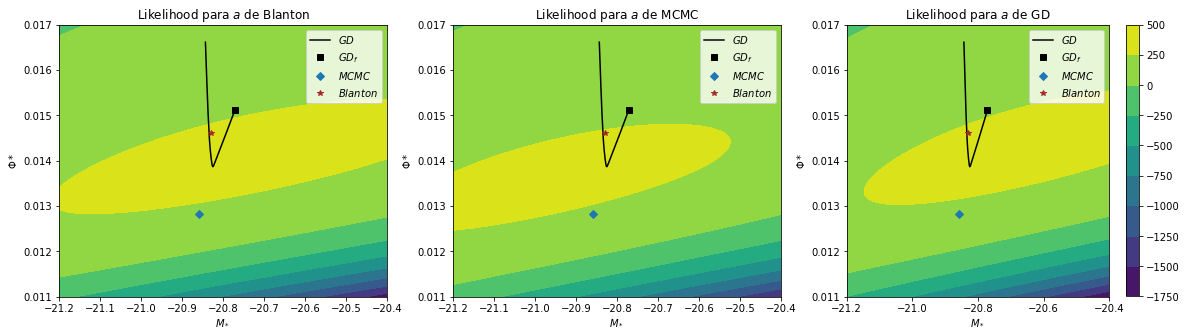

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cset1 = ax1.contourf(Mgrid,Fgrid,lkl_grid[:,:,0])
ax1.plot(M_GD,F_GD, c='k', label='$GD$')
ax1.plot(M_GD[-1],F_GD[-1], 's', c='k', label='$GD_f$')
ax1.plot(M_MC,F_MC, 'D', label= '$MCMC$')
ax1.plot(Mb,Fb, '*', c='brown', label='$Blanton$')

ax2.contourf(Mgrid,Fgrid,lkl_grid[:,:,1], cset1.levels)
ax2.plot(M_GD,F_GD, c='k',label='$GD$')
ax2.plot(M_GD[-1],F_GD[-1], 's', c='k', label='$GD_f$')
ax2.plot(M_MC,F_MC, 'D', label= '$MCMC$')
ax2.plot(Mb,Fb, '*', c='brown', label='$Blanton$')

ax3.contourf(Mgrid,Fgrid,lkl_grid[:,:,2], cset1.levels)
ax3.plot(M_GD,F_GD, c='k', label='$GD$')
ax3.plot(M_GD[-1],F_GD[-1], 's', c='k', label='$GD_f$')
ax3.plot(M_MC,F_MC, 'D', label= '$MCMC$')
ax3.plot(Mb,Fb, '*', c='brown', label='$Blanton$')

f.colorbar(cset1, ax=ax3)
ax1.set_title('Likelihood para $a$ de Blanton')
ax2.set_title('Likelihood para $a$ de MCMC')
ax3.set_title('Likelihood para $a$ de GD')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('$M_*$')
ax2.set_xlabel('$M_*$')
ax3.set_xlabel('$M_*$')
plt.setp([ax1,ax2,ax3], ylabel='$\Phi *$')
plt.show()

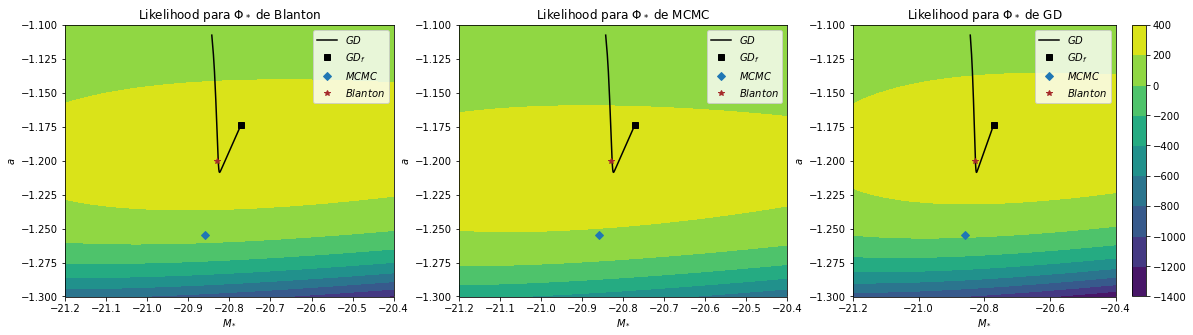

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cset1 = ax1.contourf(Mgrid,agrid,lkl_grid[:,:,3])
ax1.plot(M_GD,a_GD, c='k', label='$GD$')
ax1.plot(M_GD[-1],a_GD[-1], 's', c='k', label='$GD_f$')
ax1.plot(M_MC,a_MC, 'D', label= '$MCMC$')
ax1.plot(Mb,ab, '*', c='brown', label='$Blanton$')

ax2.contourf(Mgrid,agrid,lkl_grid[:,:,4], cset1.levels)
ax2.plot(M_GD,a_GD, c='k',label='$GD$')
ax2.plot(M_GD[-1],a_GD[-1], 's', c='k', label='$GD_f$')
ax2.plot(M_MC,a_MC, 'D', label= '$MCMC$')
ax2.plot(Mb,ab, '*', c='brown', label='$Blanton$')

ax3.contourf(Mgrid,agrid,lkl_grid[:,:,5], cset1.levels)
ax3.plot(M_GD,a_GD, c='k', label='$GD$')
ax3.plot(M_GD[-1],a_GD[-1], 's', c='k', label='$GD_f$')
ax3.plot(M_MC,a_MC, 'D', label= '$MCMC$')
ax3.plot(Mb,ab, '*', c='brown', label='$Blanton$')

f.colorbar(cset1, ax=ax3)
ax1.set_title('Likelihood para $\Phi_*$ de Blanton')
ax2.set_title('Likelihood para $\Phi_*$ de MCMC')
ax3.set_title('Likelihood para $\Phi_*$ de GD')

ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('$M_*$')
ax2.set_xlabel('$M_*$')
ax3.set_xlabel('$M_*$')
plt.setp([ax1,ax2,ax3], ylabel='$a$')
plt.show()

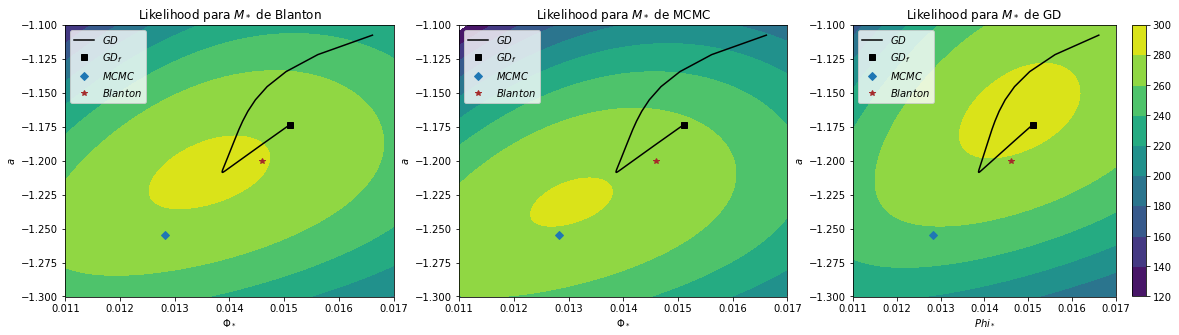

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cset1 = ax1.contourf(Fgrid,agrid,lkl_grid[:,:,6])
ax1.plot(F_GD,a_GD, c='k', label='$GD$')
ax1.plot(F_GD[-1],a_GD[-1], 's', c='k', label='$GD_f$')
ax1.plot(F_MC,a_MC, 'D', label= '$MCMC$')
ax1.plot(Fb,ab, '*', c='brown', label='$Blanton$')

ax2.contourf(Fgrid,agrid,lkl_grid[:,:,7], cset1.levels)
ax2.plot(F_GD,a_GD, c='k',label='$GD$')
ax2.plot(F_GD[-1],a_GD[-1], 's', c='k', label='$GD_f$')
ax2.plot(F_MC,a_MC, 'D', label= '$MCMC$')
ax2.plot(Fb,ab, '*', c='brown', label='$Blanton$')

ax3.contourf(Fgrid,agrid,lkl_grid[:,:,8], cset1.levels)
ax3.plot(F_GD,a_GD, c='k', label='$GD$')
ax3.plot(F_GD[-1],a_GD[-1], 's', c='k', label='$GD_f$')
ax3.plot(F_MC,a_MC, 'D', label= '$MCMC$')
ax3.plot(Fb,ab, '*', c='brown', label='$Blanton$')

f.colorbar(cset1, ax=ax3)

ax1.set_title('Likelihood para $M_*$ de Blanton')
ax2.set_title('Likelihood para $M_*$ de MCMC')
ax3.set_title('Likelihood para $M_*$ de GD')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('$\Phi_*$')
ax2.set_xlabel('$\Phi_*$')
ax3.set_xlabel('$Phi_*$')
plt.setp([ax1,ax2,ax3], ylabel='$a$')
plt.show()